In [1]:
# GPU Check
import torch

print("GPU Check:")
print(f"  CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
else:
    print("  ⚠️ NO GPU! Go to Runtime → Change runtime type → GPU")

GPU Check:
  CUDA available: True
  GPU: Tesla T4


In [2]:
# ============================================================
# Mount Google Drive
# ============================================================

from google.colab import drive

# Unmount first (in case of previous errors)
try:
    drive.flush_and_unmount()
except:
    pass

# Mount again
drive.mount('/content/drive', force_remount=True)

print("\n✓ Google Drive mounted!")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive

✓ Google Drive mounted!


In [3]:
# ============================================================
# Upload and Extract Assignment2
# ============================================================

from google.colab import files
import zipfile
import os

print("📦 Please upload Assignment2.zip")
print("(Click 'Choose Files' and select Assignment2.zip)")
print()

uploaded = files.upload()

# Extract
for filename in uploaded.keys():
    print(f"\n📂 Extracting {filename}...")
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('.')

    file_size = os.path.getsize(filename) / (1024*1024)
    print(f"✓ Extracted! (Size: {file_size:.2f} MB)")

# Verify structure
print("\n" + "="*60)
print("PROJECT STRUCTURE")
print("="*60)
!ls -la Assignment2/

print("\n" + "="*60)
print("SOURCE FILES")
print("="*60)
!ls -la Assignment2/src/

print("\n" + "="*60)
print("CONFIG FILES")
print("="*60)
!ls -la Assignment2/config/

print("\n✓ All files uploaded successfully!")

📦 Please upload Assignment2.zip
(Click 'Choose Files' and select Assignment2.zip)



Saving Assignment2.zip to Assignment2.zip

📂 Extracting Assignment2.zip...
✓ Extracted! (Size: 0.01 MB)

PROJECT STRUCTURE
total 40
drwxr-xr-x 9 root root 4096 Feb  7 20:54 .
drwxr-xr-x 1 root root 4096 Feb  7 20:54 ..
drwxr-xr-x 2 root root 4096 Feb  7 20:54 config
drwxr-xr-x 2 root root 4096 Feb  7 20:54 docs
drwxr-xr-x 3 root root 4096 Feb  7 20:54 experiments
drwxr-xr-x 2 root root 4096 Feb  7 20:54 notebooks
-rw-r--r-- 1 root root    0 Feb  7 20:54 README.md
drwxr-xr-x 2 root root 4096 Feb  7 20:54 reports
-rw-r--r-- 1 root root  108 Feb  7 20:54 requirements.txt
drwxr-xr-x 2 root root 4096 Feb  7 20:54 src
drwxr-xr-x 2 root root 4096 Feb  7 20:54 visualizations

SOURCE FILES
total 40
drwxr-xr-x 2 root root 4096 Feb  7 20:54 .
drwxr-xr-x 9 root root 4096 Feb  7 20:54 ..
-rw-r--r-- 1 root root 3377 Feb  7 20:54 data.py
-rw-r--r-- 1 root root    0 Feb  7 20:54 __init__.py
-rw-r--r-- 1 root root 9059 Feb  7 20:54 model.py
-rw-r--r-- 1 root root 7572 Feb  7 20:54 train.py
-rw-r--r-- 1

In [4]:
# ============================================================
# Load Data from Google Drive
# ============================================================

import os

# Path to tokenized data in Google Drive
data_path = "/content/drive/MyDrive/Assignment1/processed_data/tokenized"

# Verify data exists
if os.path.exists(data_path):
    print("✓ Found data in Google Drive!")
    print("\nDatasets:")
    !ls -lh {data_path}

    # Count total samples
    from datasets import load_from_disk, concatenate_datasets

    datasets = []
    for name in ["openwebtext_tokenized", "wikipedia_tokenized", "c4_tokenized"]:
        ds = load_from_disk(f"{data_path}/{name}")
        datasets.append(ds)
        print(f"  • {name}: {len(ds):,} samples")

    full_dataset = concatenate_datasets(datasets)
    print(f"\n✓ Total: {len(full_dataset):,} samples ready!")

else:
    print("✗ Data not found in Google Drive")
    print(f"Expected path: {data_path}")
    print("\nPlease upload Assignment1/processed_data/tokenized/ to Google Drive")


✓ Found data in Google Drive!

Datasets:
total 12K
drwx------ 2 root root 4.0K Feb  7 05:00 c4_tokenized
drwx------ 2 root root 4.0K Feb  7 05:00 openwebtext_tokenized
drwx------ 2 root root 4.0K Feb  7 05:00 wikipedia_tokenized
  • openwebtext_tokenized: 744,161 samples
  • wikipedia_tokenized: 742,078 samples
  • c4_tokenized: 987,148 samples

✓ Total: 2,473,387 samples ready!


In [5]:
# ============================================================
# Training Functions
# ============================================================

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import json
import os
import time
import math

# Import our model
import sys
sys.path.insert(0, '/content/Assignment2')
from src.model import MiniGPT, count_parameters

class TokenizedDataset(Dataset):
    """Dataset wrapper for tokenized data"""
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        input_ids = torch.tensor(item['input_ids'], dtype=torch.long)
        labels = input_ids.clone()
        return input_ids, labels

def calculate_perplexity(loss):
    """Calculate perplexity from loss"""
    return math.exp(min(loss, 20))  # Cap at 20 to avoid overflow

def train_epoch(model, dataloader, optimizer, device, epoch):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    num_batches = 0

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")

    for input_ids, targets in progress_bar:
        input_ids = input_ids.to(device)
        targets = targets.to(device)

        # Forward pass
        logits, loss = model(input_ids, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Track metrics
        total_loss += loss.item()
        num_batches += 1

        # Update progress bar
        avg_loss = total_loss / num_batches
        perplexity = calculate_perplexity(avg_loss)
        progress_bar.set_postfix({
            'loss': f'{avg_loss:.4f}',
            'ppl': f'{perplexity:.2f}'
        })

    avg_loss = total_loss / num_batches
    avg_perplexity = calculate_perplexity(avg_loss)

    return avg_loss, avg_perplexity

def save_checkpoint(model, optimizer, epoch, loss, perplexity, exp_name, config):
    """Save model checkpoint"""
    checkpoint_dir = f"/content/Assignment2/checkpoints/{exp_name}"
    os.makedirs(checkpoint_dir, exist_ok=True)

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'perplexity': perplexity,
        'config': config
    }

    filepath = f"{checkpoint_dir}/checkpoint_epoch{epoch}.pt"
    torch.save(checkpoint, filepath)
    print(f"  ✓ Saved: {filepath}")

print("✓ Training functions loaded!")

✓ Training functions loaded!


In [6]:
# ============================================================
# Train Experiment
# ============================================================

import yaml
from datasets import load_from_disk, concatenate_datasets

def run_experiment(config_name):
    """
    Run a training experiment

    Args:
        config_name: Name of config file (e.g., 'experiment1')
    """
    print("=" * 80)
    print(f"EXPERIMENT: {config_name.upper()}")
    print("=" * 80)

    # Load config
    config_path = f"/content/Assignment2/config/{config_name}.yaml"
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)

    exp_name = config['experiment']['name']
    print(f"\nExperiment: {exp_name}")
    print(f"Description: {config['experiment']['description']}")

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nDevice: {device}")
    if device.type == 'cuda':
        print(f"GPU: {torch.cuda.get_device_name(0)}")

    # Load data from Google Drive
    print("\n" + "=" * 80)
    print("LOADING DATA")
    print("=" * 80)

    data_path = "/content/drive/MyDrive/Assignment1/processed_data/tokenized"

    datasets = []
    for name in ["openwebtext_tokenized", "wikipedia_tokenized", "c4_tokenized"]:
        ds = load_from_disk(f"{data_path}/{name}")
        datasets.append(ds)
        print(f"  ✓ Loaded {name}: {len(ds):,} samples")

    full_dataset = concatenate_datasets(datasets)
    print(f"\n  Total samples: {len(full_dataset):,}")

    # Create dataloader
    dataset = TokenizedDataset(full_dataset)
    dataloader = DataLoader(
        dataset,
        batch_size=config['training']['batch_size'],
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    print(f"  Batch size: {config['training']['batch_size']}")
    print(f"  Total batches: {len(dataloader):,}")

    # Initialize model
    print("\n" + "=" * 80)
    print("INITIALIZING MODEL")
    print("=" * 80)

    model = MiniGPT(
        vocab_size=config['model']['vocab_size'],
        embed_dim=config['model']['embed_dim'],
        num_heads=config['model']['num_heads'],
        num_layers=config['model']['num_layers'],
        max_seq_len=config['model']['max_seq_len'],
        dropout=config['model']['dropout']
    ).to(device)

    print(f"\nModel Parameters: {count_parameters(model):,}")
    print(f"  Embedding dim: {config['model']['embed_dim']}")
    print(f"  Num heads: {config['model']['num_heads']}")
    print(f"  Num layers: {config['model']['num_layers']}")

    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['training']['learning_rate'],
        weight_decay=config['training']['weight_decay']
    )

    print(f"\nOptimizer: AdamW")
    print(f"  Learning rate: {config['training']['learning_rate']}")

    # Training history
    history = {
        'experiment': exp_name,
        'epochs': [],
        'losses': [],
        'perplexities': [],
        'time_per_epoch': []
    }

    # Training loop
    print("\n" + "=" * 80)
    print("STARTING TRAINING")
    print("=" * 80)

    start_time = time.time()

    for epoch in range(1, config['training']['num_epochs'] + 1):
        epoch_start = time.time()

        avg_loss, avg_perplexity = train_epoch(
            model, dataloader, optimizer, device, epoch
        )

        epoch_time = time.time() - epoch_start

        # Update history
        history['epochs'].append(epoch)
        history['losses'].append(avg_loss)
        history['perplexities'].append(avg_perplexity)
        history['time_per_epoch'].append(epoch_time)

        # Print summary
        print(f"\n{'='*80}")
        print(f"Epoch {epoch}/{config['training']['num_epochs']} Complete")
        print(f"{'='*80}")
        print(f"  Loss: {avg_loss:.4f}")
        print(f"  Perplexity: {avg_perplexity:.2f}")
        print(f"  Time: {epoch_time/60:.1f} minutes")

        # Save checkpoint
        save_checkpoint(model, optimizer, epoch, avg_loss, avg_perplexity, exp_name, config)

    total_time = time.time() - start_time

    # Save history
    history_dir = f"/content/Assignment2/checkpoints/{exp_name}"
    os.makedirs(history_dir, exist_ok=True)
    with open(f"{history_dir}/training_history.json", 'w') as f:
        json.dump(history, f, indent=2)

    # Final summary
    print("\n" + "=" * 80)
    print("TRAINING COMPLETED")
    print("=" * 80)
    print(f"\nExperiment: {exp_name}")
    print(f"Final Loss: {history['losses'][-1]:.4f}")
    print(f"Final Perplexity: {history['perplexities'][-1]:.2f}")
    print(f"Total Time: {total_time/60:.1f} minutes")
    print(f"\nCheckpoints saved in: /content/Assignment2/checkpoints/{exp_name}")
    print("=" * 80)

    return model, history

# Ready to run!
print("✓ Training script ready!")
print("\n" + "="*80)
print("WAITING FOR DATA UPLOAD TO COMPLETE...")
print("="*80)
print("\nOnce upload finishes, run:")
print("  model1, history1 = run_experiment('experiment1')")
print("="*80)

✓ Training script ready!

WAITING FOR DATA UPLOAD TO COMPLETE...

Once upload finishes, run:
  model1, history1 = run_experiment('experiment1')


In [7]:
# ============================================================
# Create Complete Config Files
# ============================================================

import yaml
import os

os.makedirs('/content/Assignment2/config', exist_ok=True)

# Base Config
base_config = {
    'model': {
        'vocab_size': 50257,
        'embed_dim': 128,
        'num_heads': 4,
        'num_layers': 2,
        'max_seq_len': 128,
        'dropout': 0.1
    },
    'training': {
        'batch_size': 32,
        'learning_rate': 0.001,
        'weight_decay': 0.01,
        'num_epochs': 3
    },
    'experiment': {
        'name': 'baseline',
        'description': 'Baseline: 2 layers, embed_dim=128, lr=1e-3'
    }
}

with open('/content/Assignment2/config/base_config.yaml', 'w') as f:
    yaml.dump(base_config, f, default_flow_style=False)

# Experiment 1
exp1 = base_config.copy()
exp1['experiment'] = {
    'name': 'exp1_2layers_lr1e3',
    'description': '2 layers, embed_dim=128, lr=1e-3'
}

with open('/content/Assignment2/config/experiment1.yaml', 'w') as f:
    yaml.dump(exp1, f, default_flow_style=False)

# Experiment 2 (lower LR)
exp2 = base_config.copy()
exp2['training']['learning_rate'] = 0.0005
exp2['experiment'] = {
    'name': 'exp2_2layers_lr5e4',
    'description': '2 layers, embed_dim=128, lr=5e-4'
}

with open('/content/Assignment2/config/experiment2.yaml', 'w') as f:
    yaml.dump(exp2, f, default_flow_style=False)

# Experiment 3 (wider model)
exp3 = base_config.copy()
exp3['model']['embed_dim'] = 256
exp3['training']['batch_size'] = 16  # Smaller batch for larger model
exp3['experiment'] = {
    'name': 'exp3_2layers_embed256',
    'description': '2 layers, embed_dim=256, lr=1e-3'
}

with open('/content/Assignment2/config/experiment3.yaml', 'w') as f:
    yaml.dump(exp3, f, default_flow_style=False)

print("✓ All config files created!")
print("\nConfigs:")
print("  • experiment1: 2 layers, embed=128, lr=1e-3")
print("  • experiment2: 2 layers, embed=128, lr=5e-4")
print("  • experiment3: 2 layers, embed=256, lr=1e-3, batch=16")

✓ All config files created!

Configs:
  • experiment1: 2 layers, embed=128, lr=1e-3
  • experiment2: 2 layers, embed=128, lr=5e-4
  • experiment3: 2 layers, embed=256, lr=1e-3, batch=16


In [8]:
# ============================================================
# Fix model.py - Correct Loss Calculation
# ============================================================

%%writefile /content/Assignment2/src/model.py
"""
Mini-GPT: Fixed version
"""

import torch
import torch.nn as nn
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv_proj = nn.Linear(embed_dim, 3 * embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)

    def forward(self, x, mask=None):
        batch_size, seq_len, embed_dim = x.shape

        qkv = self.qkv_proj(x)
        qkv = qkv.reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        scores = torch.matmul(q, k.transpose(-2, -1)) / self.scale

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        attn_output = torch.matmul(attn_weights, v)
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.reshape(batch_size, seq_len, embed_dim)
        output = self.out_proj(attn_output)

        return output

class FeedForward(nn.Module):
    def __init__(self, embed_dim, ff_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, ff_dim)
        self.fc2 = nn.Linear(ff_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.feed_forward = FeedForward(embed_dim, ff_dim, dropout)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.attention(self.ln1(x), mask)
        x = x + self.dropout(attn_output)

        ff_output = self.feed_forward(self.ln2(x))
        x = x + self.dropout(ff_output)

        return x

class MiniGPT(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=4, num_layers=2,
                 max_seq_len=128, dropout=0.1):
        super().__init__()

        self.embed_dim = embed_dim
        self.max_seq_len = max_seq_len

        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(max_seq_len, embed_dim)

        ff_dim = 4 * embed_dim
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

        self.ln_f = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size, bias=False)
        self.dropout = nn.Dropout(dropout)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, input_ids, targets=None):
        batch_size, seq_len = input_ids.shape

        mask = torch.tril(torch.ones(seq_len, seq_len)).to(input_ids.device)
        mask = mask.unsqueeze(0).unsqueeze(0)

        token_embeds = self.token_embedding(input_ids)
        positions = torch.arange(0, seq_len, device=input_ids.device).unsqueeze(0)
        pos_embeds = self.position_embedding(positions)

        x = self.dropout(token_embeds + pos_embeds)

        for block in self.blocks:
            x = block(x, mask)

        x = self.ln_f(x)
        logits = self.head(x)

        # FIXED: Proper next-token prediction loss
        loss = None
        if targets is not None:
            # Shift for next-token prediction
            shift_logits = logits[:, :-1, :].contiguous()
            shift_targets = targets[:, 1:].contiguous()

            loss = nn.functional.cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_targets.view(-1)
            )

        return logits, loss

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("✓ model.py fixed and saved!")

Overwriting /content/Assignment2/src/model.py


In [9]:
# Change all experiments to 2 epochs (save time)
import yaml

for exp in ['experiment1', 'experiment2', 'experiment3']:
    path = f'/content/Assignment2/config/{exp}.yaml'
    with open(path, 'r') as f:
        config = yaml.safe_load(f)

    config['training']['num_epochs'] = 2  # Change to 2

    with open(path, 'w') as f:
        yaml.dump(config, f)

    print(f"✓ {exp}: num_epochs = 2")

print("\n✓ All configs updated to 2 epochs!")

✓ experiment1: num_epochs = 2
✓ experiment2: num_epochs = 2
✓ experiment3: num_epochs = 2

✓ All configs updated to 2 epochs!


In [10]:
# Force reload model
import importlib
import sys

if 'src.model' in sys.modules:
    del sys.modules['src.model']

sys.path.insert(0, '/content/Assignment2')
from src.model import MiniGPT, count_parameters

print("✓ Model reloaded!")

✓ model.py fixed and saved!
✓ Model reloaded!


In [11]:
# ============================================================
# Start Experiment 1
# ============================================================

model1, history1 = run_experiment('experiment1')

EXPERIMENT: EXPERIMENT1

Experiment: exp1_2layers_lr1e3
Description: 2 layers, embed_dim=128, lr=1e-3

Device: cuda
GPU: Tesla T4

LOADING DATA
  ✓ Loaded openwebtext_tokenized: 744,161 samples
  ✓ Loaded wikipedia_tokenized: 742,078 samples
  ✓ Loaded c4_tokenized: 987,148 samples

  Total samples: 2,473,387
  Batch size: 32
  Total batches: 77,294

INITIALIZING MODEL

Model Parameters: 13,278,976
  Embedding dim: 128
  Num heads: 4
  Num layers: 2

Optimizer: AdamW
  Learning rate: 0.001

STARTING TRAINING


Epoch 1: 100%|██████████| 77294/77294 [2:07:16<00:00, 10.12it/s, loss=5.2789, ppl=196.16]



Epoch 1/2 Complete
  Loss: 5.2789
  Perplexity: 196.16
  Time: 127.3 minutes
  ✓ Saved: /content/Assignment2/checkpoints/exp1_2layers_lr1e3/checkpoint_epoch1.pt


Epoch 2: 100%|██████████| 77294/77294 [2:07:15<00:00, 10.12it/s, loss=5.0772, ppl=160.32]



Epoch 2/2 Complete
  Loss: 5.0772
  Perplexity: 160.32
  Time: 127.3 minutes
  ✓ Saved: /content/Assignment2/checkpoints/exp1_2layers_lr1e3/checkpoint_epoch2.pt

TRAINING COMPLETED

Experiment: exp1_2layers_lr1e3
Final Loss: 5.0772
Final Perplexity: 160.32
Total Time: 254.5 minutes

Checkpoints saved in: /content/Assignment2/checkpoints/exp1_2layers_lr1e3


In [15]:
import json

# Check Exp 1
with open("/content/Assignment2/checkpoints/exp1_2layers_lr1e3/training_history.json") as f:
    h1 = json.load(f)

print("Experiment 1 , loss:")
for i, loss in enumerate(h1['losses'], 1):
    print(f"  Epoch {i}: Loss = {loss:.10f}")

Experiment 1 , loss:
  Epoch 1: Loss = 5.2789207259
  Epoch 2: Loss = 5.0771765959


In [16]:
# ============================================================
# Start Experiment 2
# ============================================================

model2, history2 = run_experiment('experiment2')

EXPERIMENT: EXPERIMENT2

Experiment: exp2_2layers_lr5e4
Description: 2 layers, embed_dim=128, lr=5e-4

Device: cuda
GPU: Tesla T4

LOADING DATA
  ✓ Loaded openwebtext_tokenized: 744,161 samples
  ✓ Loaded wikipedia_tokenized: 742,078 samples
  ✓ Loaded c4_tokenized: 987,148 samples

  Total samples: 2,473,387
  Batch size: 32
  Total batches: 77,294

INITIALIZING MODEL

Model Parameters: 13,278,976
  Embedding dim: 128
  Num heads: 4
  Num layers: 2

Optimizer: AdamW
  Learning rate: 0.0005

STARTING TRAINING


Epoch 1: 100%|██████████| 77294/77294 [2:07:42<00:00, 10.09it/s, loss=5.2869, ppl=197.72]



Epoch 1/2 Complete
  Loss: 5.2869
  Perplexity: 197.72
  Time: 127.7 minutes
  ✓ Saved: /content/Assignment2/checkpoints/exp2_2layers_lr5e4/checkpoint_epoch1.pt


Epoch 2: 100%|██████████| 77294/77294 [2:07:43<00:00, 10.09it/s, loss=5.0670, ppl=158.69]



Epoch 2/2 Complete
  Loss: 5.0670
  Perplexity: 158.69
  Time: 127.7 minutes
  ✓ Saved: /content/Assignment2/checkpoints/exp2_2layers_lr5e4/checkpoint_epoch2.pt

TRAINING COMPLETED

Experiment: exp2_2layers_lr5e4
Final Loss: 5.0670
Final Perplexity: 158.69
Total Time: 255.4 minutes

Checkpoints saved in: /content/Assignment2/checkpoints/exp2_2layers_lr5e4


In [17]:
# ============================================================
# Start Experiment 3
# ============================================================

model3, history3 = run_experiment('experiment3')

EXPERIMENT: EXPERIMENT3

Experiment: exp3_2layers_embed256
Description: 2 layers, embed_dim=256, lr=1e-3

Device: cuda
GPU: Tesla T4

LOADING DATA
  ✓ Loaded openwebtext_tokenized: 744,161 samples
  ✓ Loaded wikipedia_tokenized: 742,078 samples
  ✓ Loaded c4_tokenized: 987,148 samples

  Total samples: 2,473,387
  Batch size: 16
  Total batches: 154,587

INITIALIZING MODEL

Model Parameters: 27,344,384
  Embedding dim: 256
  Num heads: 4
  Num layers: 2

Optimizer: AdamW
  Learning rate: 0.0005

STARTING TRAINING


Epoch 1: 100%|██████████| 154587/154587 [3:26:22<00:00, 12.48it/s, loss=5.0627, ppl=158.01]



Epoch 1/2 Complete
  Loss: 5.0627
  Perplexity: 158.01
  Time: 206.4 minutes
  ✓ Saved: /content/Assignment2/checkpoints/exp3_2layers_embed256/checkpoint_epoch1.pt


Epoch 2: 100%|██████████| 154587/154587 [3:26:20<00:00, 12.49it/s, loss=4.8460, ppl=127.23]



Epoch 2/2 Complete
  Loss: 4.8460
  Perplexity: 127.23
  Time: 206.3 minutes
  ✓ Saved: /content/Assignment2/checkpoints/exp3_2layers_embed256/checkpoint_epoch2.pt

TRAINING COMPLETED

Experiment: exp3_2layers_embed256
Final Loss: 4.8460
Final Perplexity: 127.23
Total Time: 412.7 minutes

Checkpoints saved in: /content/Assignment2/checkpoints/exp3_2layers_embed256


In [7]:
# Find ANY .pt or .json files
!find /content -name "*.pt" 2>/dev/null | head -20
!find /content -name "*.json" 2>/dev/null | head -20

/content/.config/.last_update_check.json
/content/sample_data/anscombe.json


In [8]:
from google.colab import drive
drive.mount('/content/drive')

# Check backups
!ls -lh /content/drive/MyDrive/Assignment2_Results/checkpoints/

Mounted at /content/drive
total 12K
drwx------ 2 root root 4.0K Feb  8 14:47 exp1_2layers_lr1e3
drwx------ 2 root root 4.0K Feb  8 14:47 exp2_2layers_lr5e4
drwx------ 2 root root 4.0K Feb  8 14:47 exp3_2layers_embed256


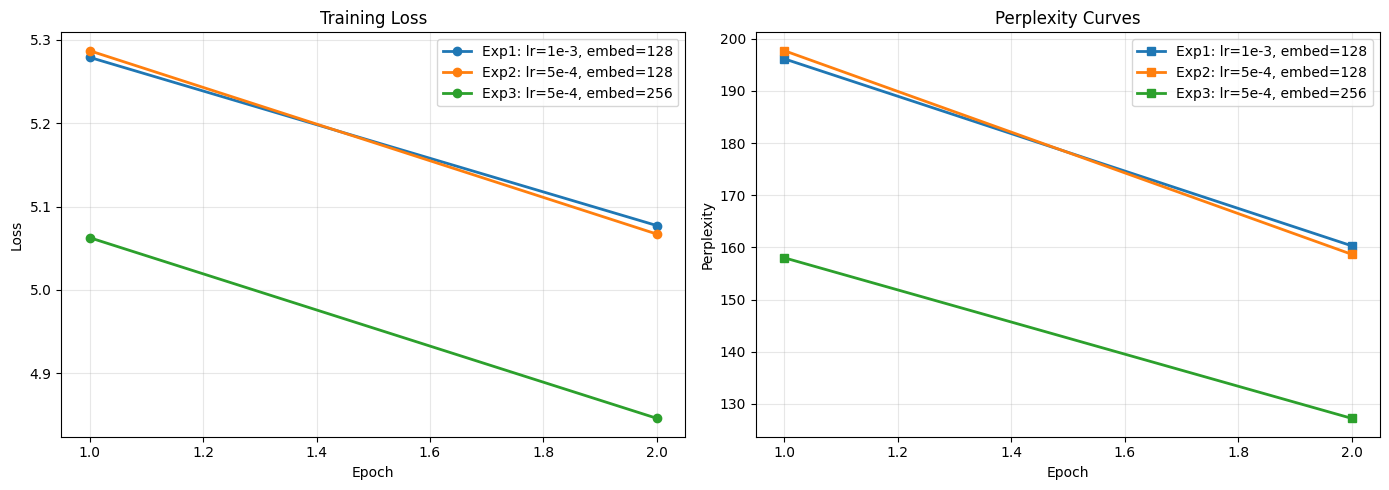

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# ============================================================
# Generate Visualizations
# ============================================================

import matplotlib.pyplot as plt
import json

# Load from Drive
results = {}
exp_names = {
    'exp1_2layers_lr1e3': 'Exp1: lr=1e-3, embed=128',
    'exp2_2layers_lr5e4': 'Exp2: lr=5e-4, embed=128',
    'exp3_2layers_embed256': 'Exp3: lr=5e-4, embed=256'
}

for exp_id, label in exp_names.items():
    path = f"/content/drive/MyDrive/Assignment2_Results/checkpoints/{exp_id}/training_history.json"
    with open(path) as f:
        results[label] = json.load(f)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for label, data in results.items():
    ax1.plot(data['epochs'], data['losses'], marker='o', label=label, linewidth=2)
    ax2.plot(data['epochs'], data['perplexities'], marker='s', label=label, linewidth=2)

ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
ax1.set_title('Training Loss'); ax1.legend(); ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Epoch'); ax2.set_ylabel('Perplexity')
ax2.set_title('Perplexity Curves'); ax2.legend(); ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/training_curves.png', dpi=300)
plt.show()

from google.colab import files
files.download('/content/training_curves.png')

In [10]:
# Download final checkpoint (for submission)
!cp /content/drive/MyDrive/Assignment2_Results/checkpoints/exp3_2layers_embed256/checkpoint_epoch2.pt /content/mini_gpt_checkpoint.pt

from google.colab import files
files.download('/content/mini_gpt_checkpoint.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# Copy to Drive
!cp -r /content/Assignment2/checkpoints /content/drive/MyDrive/Assignment2_checkpoints

In [20]:
# Backup all results to Google Drive
!mkdir -p /content/drive/MyDrive/Assignment2_Results

# Copy checkpoints
!cp -r /content/Assignment2/checkpoints /content/drive/MyDrive/Assignment2_Results/

# Copy any logs
!cp -r /content/Assignment2/logs /content/drive/MyDrive/Assignment2_Results/ 2>/dev/null || true

print("✓ Backed up to Google Drive: Assignment2_Results/")
!ls -lh /content/drive/MyDrive/Assignment2_Results/

✓ Backed up to Google Drive: Assignment2_Results/
total 4.0K
drwx------ 5 root root 4.0K Feb  8 14:47 checkpoints
